# Modelos Bagging

La muestra con la que se trabajará es un archivo llamado telecom_churn.csv, que contiene los siguientes atributos asociados a clientes:
1. Churn (Variable objetivo): valor 1 si el cliente canceló el servicio, 0 si no
2. AccountWeeks: número de semanas que el cliente ha tenido activa la cuenta
3. ContractRenewal: toma el valor 1 si el cliente ha renovado recientemente el contrato, 0 en caso contrario
4. DataPlan: valor 1 si el cliente tiene plan de datos, 0 en caso contrario
5. DataUsage: Gigabytes de uso mensual de datos
6. CustServCalls: número de llamadas al servicio de atención al cliente
7. DayMins: promedio de minutos diurnos al mes
8. DayCalls: número medio de llamadas diurnas
9. MonthlyCharge: factura mensual media
10. OverageFee: mayor cuota de exceso en los últimos 12 meses
11. RoamMin: minutos de Roaming

In [68]:
# Bibliotecas Comunes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mode

#Metricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

# Identificación de outliers
from sklearn.ensemble import IsolationForest

# Evaluacion de Modelos y Seleccion de Features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Guardar modelos entrenados
from joblib import dump

### Actividad 1

Importa las librerías necesarias y la base de datos, y realiza un análisis por variable usando visualizaciones. Debes considerar las posibles correlaciones y representarlas en un heatmap.

In [69]:
df = pd.read_csv("telecom_churn.csv", delimiter=",", encoding="utf-8", header=0)
df

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


In [70]:
# Tipos de Datos y No Nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [71]:
# Valores Nulos
missing_values=df.apply(lambda x: sum(x.isnull()),axis=0)
print(missing_values)

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64


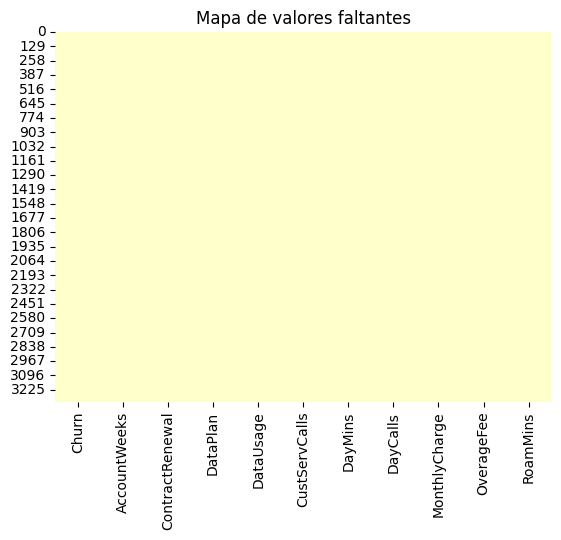

In [72]:
sns.heatmap(df.isnull(), cbar=False, cmap="YlOrRd")
plt.title("Mapa de valores faltantes")
plt.show()

In [73]:
# Método para graficar
def plot_df_columns(
    df: pd.DataFrame,
    tipo: str = "histplot",
    figsize=(14, 8),
    kde: bool = False,
    bins_list=None,
    stat: str = "count"
):
    """
    Grafica todas las columnas numéricas de un DataFrame en subplots.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    tipo : {"hisplot","histplot","boxplot"}
        Tipo de gráfico por subplot. Se acepta el typo "hisplot" (histplot).
    figsize : tuple
        Tamaño de la figura en pulgadas (ancho, alto) para plt.subplots.
    kde : bool
        Si True, añade curva KDE en histplot. Ignorado en boxplot.
    bins_list : list | None
        Lista con los bins a usar para cada columna (solo histplot).
        - Puede contener enteros, secuencias de bordes, o None.
        - Si la lista es más corta que el número de columnas, las
          faltantes usarán "auto".
    stat : {"count","frequency","density","probability"}
        Estadístico para histplot (ignorado en boxplot).
    """
    # Normalizar tipo
    tipo = (tipo or "").lower().strip()
    if tipo == "hisplot":  # aceptar el typo pedido
        tipo = "histplot"
    if tipo not in {"histplot", "boxplot"}:
        raise ValueError('tipo debe ser "hisplot"/"histplot" o "boxplot".')

    # Solo columnas numéricas (ambos gráficos requieren datos numéricos)
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(cols) == 0:
        raise ValueError("No hay columnas numéricas para graficar.")

    n = len(cols)
    # Distribuir subplots en una cuadrícula "cuadrada"
    ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    # Preparar bins por columna si corresponde
    if bins_list is None:
        bins_list = []
    # Asegurar longitud
    if len(bins_list) < n:
        bins_list = list(bins_list) + ["auto"] * (n - len(bins_list))

    for i, col in enumerate(cols):
        ax = axes[i]
        serie = df[col].dropna()

        if tipo == "histplot":
            bins = bins_list[i]
            sns.histplot(serie, bins=bins, kde=kde, stat=stat, ax=ax)
        else:  # boxplot
            sns.boxplot(x=serie, ax=ax)

        ax.set_title(str(col))

    # Ocultar axes no usados si la rejilla es más grande que n
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [75]:
columns_numeric_categorical = ["Churn", "ContractRenewal", "DataPlan"]
columns_numeric_continuous = ["AccountWeeks", "DataUsage", "CustServCalls", "DayMins", "DayCalls", "MonthlyCharge", "OverageFee", "RoamMins"]

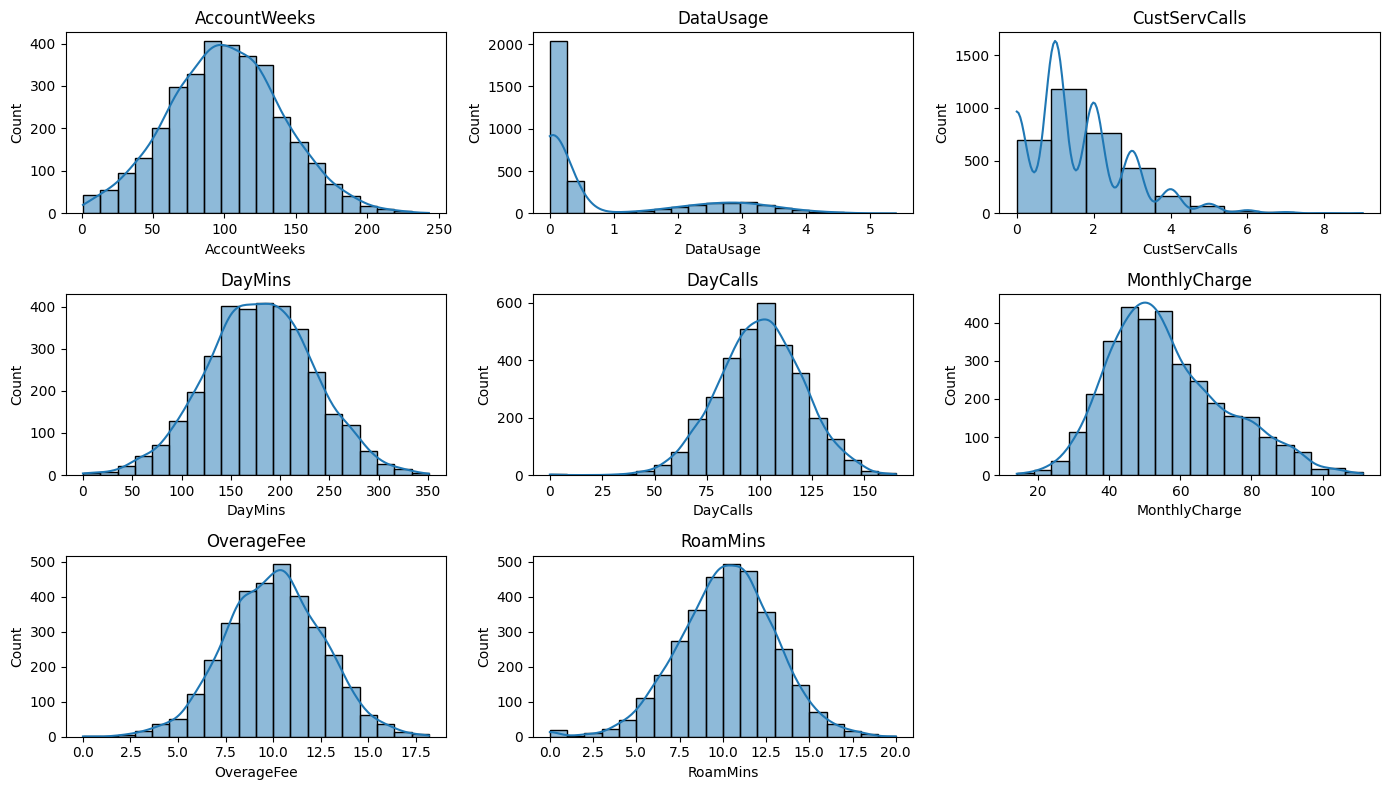

In [76]:
# Graficando histogramas para columnas numericas conitnuas (No categóricas)

plot_df_columns(df= df[columns_numeric_continuous], tipo= "histplot", figsize=(14, 8), kde= True, bins_list=[20, 20, 10, 20, 20, 20, 20, 20], stat= "count")

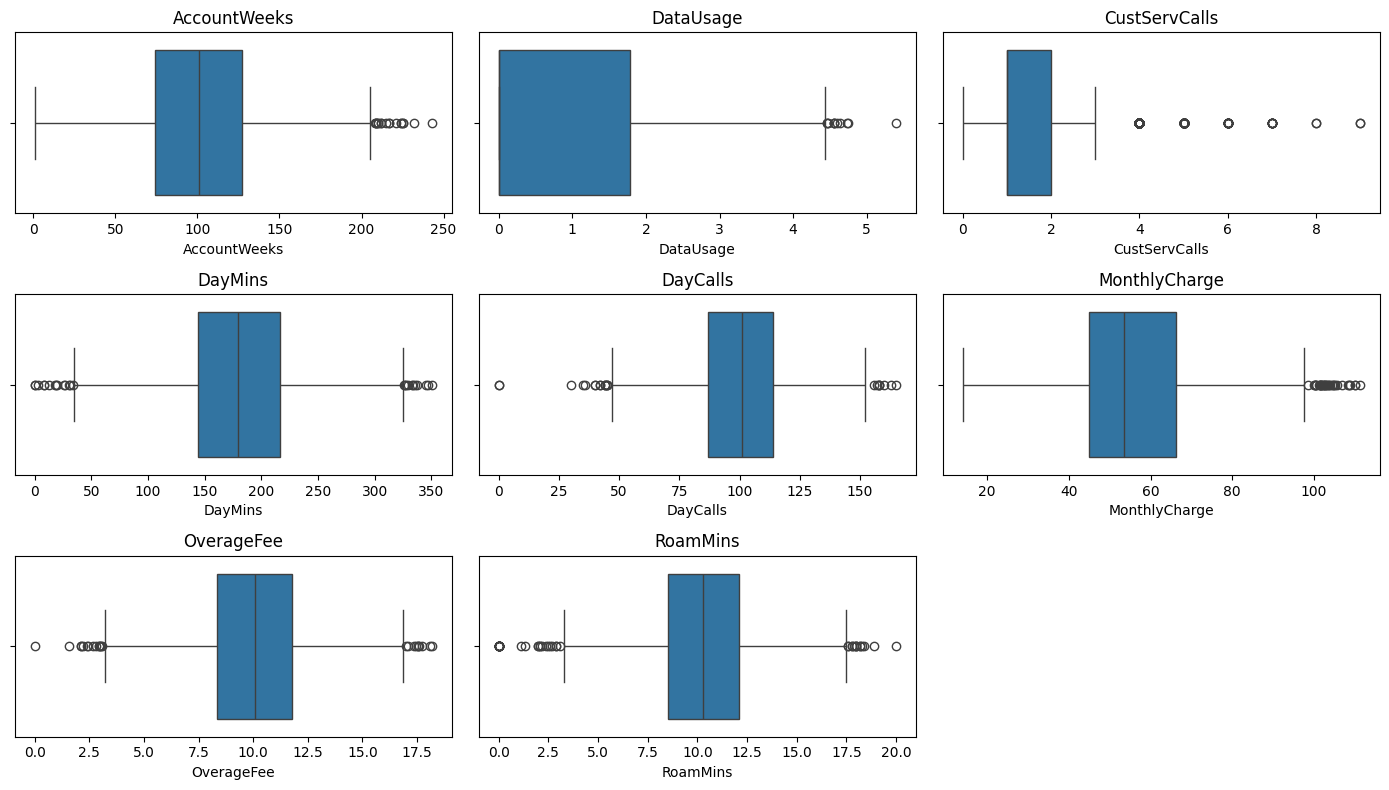

In [77]:
# Graficando histogramas para columnas numericas conitnuas (No categóricas)

plot_df_columns(df= df[columns_numeric_continuous], tipo= "boxplot", figsize=(14, 8), kde= True, bins_list=[20, 20, 10, 20, 20, 20, 20, 20], stat= "count")

In [78]:
def df_outliers_analysis(df:pd.DataFrame, columns_to_analize:list):

    # Copia de trabajo
    df_ = df.copy()

    # Configurar Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)

    # Detectar outliers columna por columna
    outlier_flags = {}
    for col in columns_to_analize:
        values = df[[col]].dropna()
        preds = iso.fit_predict(values)  # -1 = outlier, 1 = normal
        mask = pd.Series(preds, index=values.index).map({1: False, -1: True})
        outlier_flags[col] = mask

    # ---------------------------------------
    # Graficar matriz de histogramas
    
    n_cols = 3
    n_rows = int(np.ceil(len(columns_to_analize) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns_to_analize):
        ax = axes[i]

        # Histogram normales
        sns.histplot(df[col], bins=30, kde=False, color="skyblue", ax=ax, label="Normal")

        # Superponer outliers en rojo
        out_vals = df.loc[outlier_flags[col], col]
        sns.histplot(out_vals, bins=30, kde=False, color="red", ax=ax, label="Outliers")

        ax.set_title(f"Histograma con Outliers - {col}")
        ax.legend()

    # Quitar ejes vacíos si sobran
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(outlier_flags)

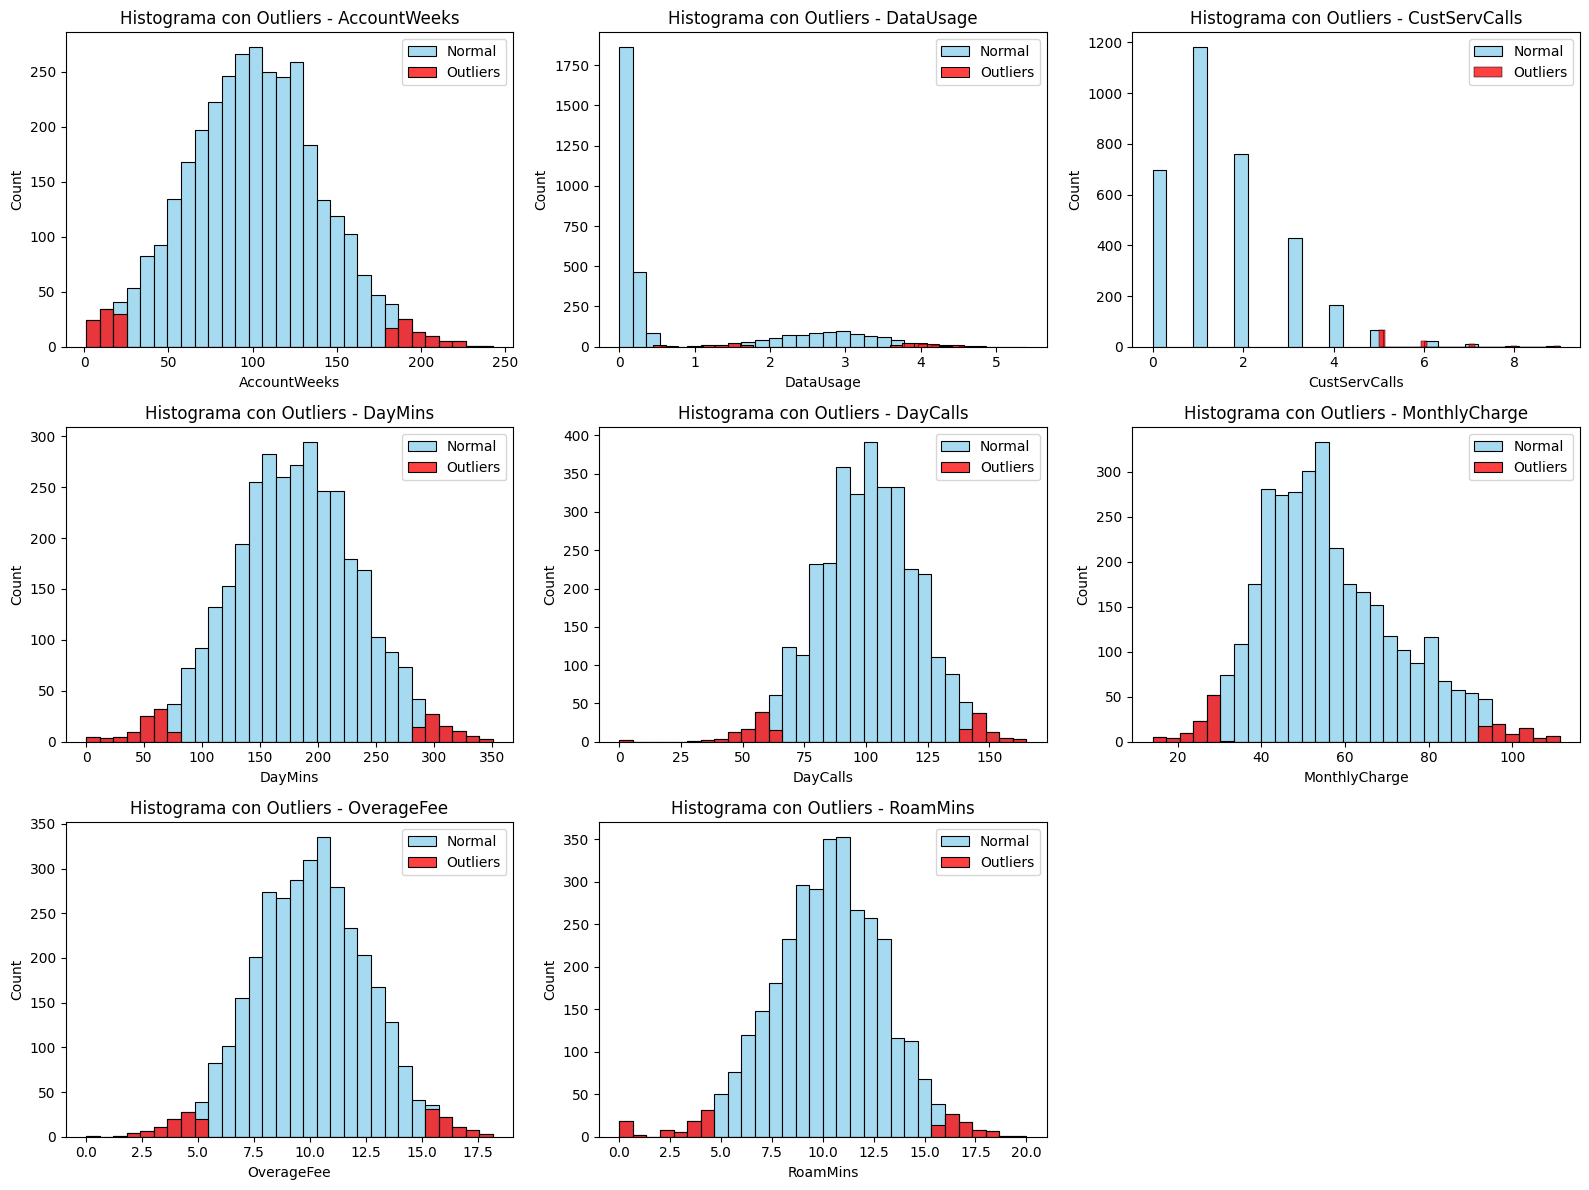

In [79]:
df_outliers = df_outliers_analysis(df=df, columns_to_analize=columns_numeric_continuous)

In [80]:
# Aunque detectamos outliers, ocuparemos todos los datos

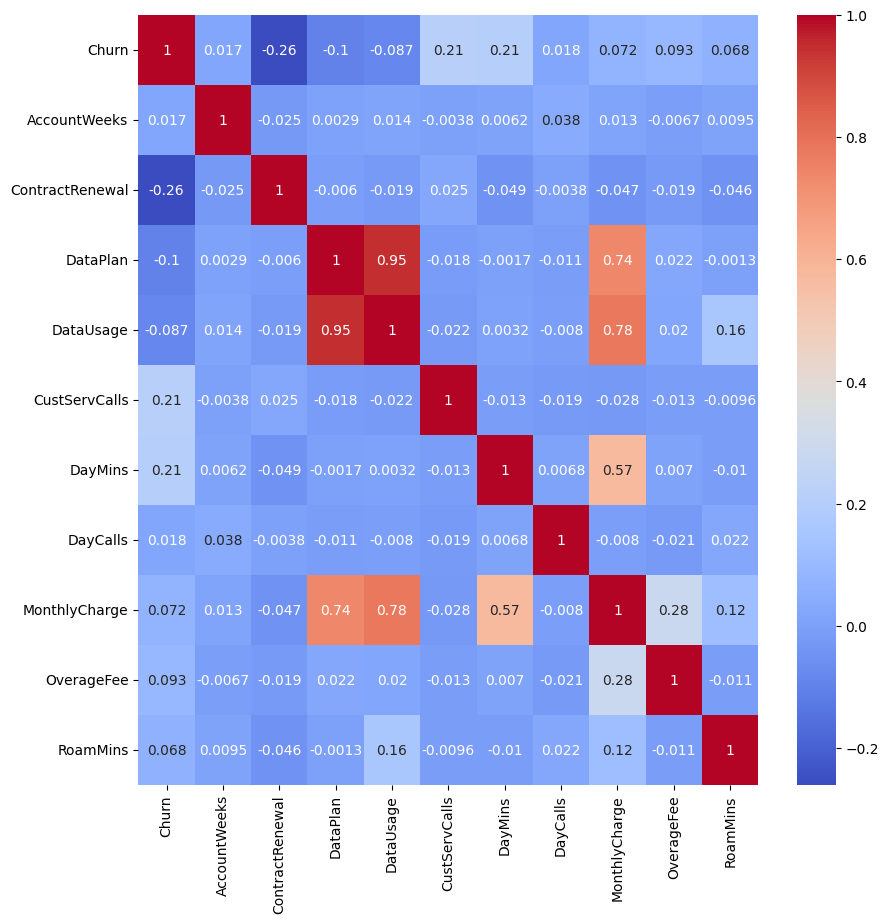

In [13]:
# Matriz de Correlacion de Pearson para relacionar variables numericas, no utilizaremos chi-cuadrado o ANOVA 
# Graficar Correlaciones
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method="pearson"), annot=True, cmap='coolwarm')
plt.show()

### Actividad 2

Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando búsqueda por grilla con 5 kfold:

max_depth: [5, 10, 15, 20, 25]

min_samples_split: [0.01, 0.02, 0.03, 0.04]

In [81]:
# Generar valores de X
X = df.drop("Churn", axis=1)
X

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...
3328,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


In [82]:
# Generar valores de y
y = df[["Churn"]]
y

,Churn
0,0
1,0
2,0
3,0
4,0
...,...
3328,0
3329,0
3330,0
3331,0


In [83]:
# Generar Datos de Entrenamiento y Testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
X_train

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
817,243,1,0,0.00,2,95.5,92,31.0,8.19,6.6
1373,108,1,0,0.00,4,112.0,105,36.0,9.69,4.1
679,75,0,0,0.00,1,222.4,78,66.0,16.35,8.7
56,141,1,0,0.00,1,126.9,98,37.0,9.00,8.0
1993,86,1,0,0.35,0,216.3,96,63.5,13.32,4.5
...,...,...,...,...,...,...,...,...,...,...
1095,106,1,0,0.00,1,274.4,120,64.0,9.93,6.0
1130,122,1,0,0.00,1,35.1,62,22.0,9.04,12.7
1294,66,1,0,0.24,1,87.6,76,40.4,13.10,9.2
860,169,1,0,0.00,2,179.2,111,46.0,8.76,9.9


In [85]:
y_train

,Churn
817,0
1373,1
679,1
56,0
1993,0
...,...
1095,0
1130,0
1294,0
860,0


In [86]:
len(y_train)

2666

In [87]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_train = y_train.to_numpy().ravel()

In [88]:
X_train

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,243,1,0,0.00,2,95.5,92,31.0,8.19,6.6
1,108,1,0,0.00,4,112.0,105,36.0,9.69,4.1
2,75,0,0,0.00,1,222.4,78,66.0,16.35,8.7
3,141,1,0,0.00,1,126.9,98,37.0,9.00,8.0
4,86,1,0,0.35,0,216.3,96,63.5,13.32,4.5
...,...,...,...,...,...,...,...,...,...,...
2661,106,1,0,0.00,1,274.4,120,64.0,9.93,6.0
2662,122,1,0,0.00,1,35.1,62,22.0,9.04,12.7
2663,66,1,0,0.24,1,87.6,76,40.4,13.10,9.2
2664,169,1,0,0.00,2,179.2,111,46.0,8.76,9.9


In [89]:
y_train

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [90]:
# Funciones para evaluar métricas

def model_evaluation_regressor(y_test, y_pred, model_name:str):
    dict_results = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    return pd.DataFrame(dict_results, index=[f"{model_name}"]) 

def model_evaluation_classifier(y_test, y_pred, model_name:str):
    dict_results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    return pd.DataFrame(dict_results, index=[f"{model_name}"]) 

In [91]:
# Modelo Arbol de decisión para clasificar
tree_clf = DecisionTreeClassifier(random_state=42)

# Entrenar
tree_clf.fit(X_train, y_train)

# Prediccion
y_pred_tree = tree_clf.predict(X_test)

# Evaluacion
df_results_tree = model_evaluation_classifier(y_test, y_pred_tree, "model_tree_clf")
df_results_tree

,Accuracy,Precision,Recall,F1 Score
model_tree_clf,0.875562,0.591837,0.574257,0.582915


In [92]:
# Vamos a mejorar el modelo iterando varios hiperparametros através de GridSearchCV

# Aplicar ColumnTransformer para escalar columnas continuas
preprocessor_tree_clf = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), columns_numeric_continuous),   # escalar continuas
    ],
    remainder="passthrough",                    # dejar dummies/otras numéricas igual
    verbose_feature_names_out=False
)

# Pipelines para cada modelo
pipe_tree_clf = Pipeline([
    ("prep", preprocessor_tree_clf),
    ("model", tree_clf)
])

# Grid del Modelo
param_grid_tree_clf = {
    "model__max_depth": [5, 10, 15, 20, 25], # máxima profundidad del árbol
    "model__min_samples_split": [0.01, 0.02, 0.03, 0.04] 
}

# GridSearchCV
grid_tree_clf = GridSearchCV(pipe_tree_clf, param_grid_tree_clf, cv=5, scoring="accuracy")

# Entrenar modelo
grid_tree_clf.fit(X_train, y_train)

# Guardar mejor modelo
best_tree_clf = grid_tree_clf.best_estimator_

# Generar predicciones con el mejor modelo
y_pred_best_tree_clf = best_tree_clf.predict(X_test)


In [93]:
# Mejores hiperparametros

grid_tree_clf.best_params_

{'model__max_depth': 5, 'model__min_samples_split': 0.03}

In [94]:
# Evaluacion de desempeño con los datos de entrenamiento
grid_tree_clf_accuracy = grid_tree_clf.best_score_
grid_tree_clf_accuracy
print(f"Accuracy en test set: {grid_tree_clf_accuracy:.3f}")

Accuracy en test set: 0.931


In [95]:
# Evaluacion de desempeño con el mejor modelo y los datos de predicción
df_results_best_tree_clf = model_evaluation_classifier(y_test, y_pred_best_tree_clf, "model_best_tree_clf")
df_results_best_tree_clf


,Accuracy,Precision,Recall,F1 Score
model_best_tree_clf,0.911544,0.85,0.50495,0.63354


In [96]:
pd.concat([df_results_tree, df_results_best_tree_clf])

,Accuracy,Precision,Recall,F1 Score
model_tree_clf,0.875562,0.591837,0.574257,0.582915
model_best_tree_clf,0.911544,0.850000,0.504950,0.633540


In [97]:
# Claramente mejora el modelo iterando con varios hiperparametros y eligiendo el mejor estimador de arbol de decision

### Actividad 3

Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

In [30]:
# Aplicar SMOTE SOLO en el train
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [31]:
X_train_res

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,243,1,0,0.000000,2,95.500000,92,31.000000,8.190000,6.600000
1,108,1,0,0.000000,4,112.000000,105,36.000000,9.690000,4.100000
2,75,0,0,0.000000,1,222.400000,78,66.000000,16.350000,8.700000
3,141,1,0,0.000000,1,126.900000,98,37.000000,9.000000,8.000000
4,86,1,0,0.350000,0,216.300000,96,63.500000,13.320000,4.500000
...,...,...,...,...,...,...,...,...,...,...
4563,131,0,1,2.883078,2,225.987206,102,82.726976,9.025504,10.660893
4564,127,0,0,0.000000,1,180.034347,109,44.808881,8.021585,8.445363
4565,88,1,0,0.000000,1,325.121679,110,70.930254,8.870867,8.089161
4566,209,1,0,0.061703,2,247.293190,124,64.153584,12.522618,9.599929


In [32]:
y_train_res

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [33]:
len(y_train_res)

4568

In [34]:

# Modelo base
tree_clf_best = DecisionTreeClassifier(max_depth=5, min_samples_split=0.03, random_state=42)

# BaggingClassifier
bagging_tree = BaggingClassifier(
    estimator=tree_clf_best,  # Modelo base
    n_estimators=200,         # Número de modelos base
    max_samples=0.8,          # % del dataset para cada modelo
    bootstrap=True,           # Bootstrap sampling
    oob_score=True,           # Activar evaluación OOB
    random_state=42
)

# Entrenar modelo
bagging_tree.fit(X_train_res, y_train_res)

# Predecir
y_pred_bagging_tree = bagging_tree.predict(X_test)

In [36]:
# Evaluación con datos de entrenamiento con muestras out-of-bag

oob_score_bagging_tree = bagging_tree.oob_score_
print(f"OOB score: {oob_score_bagging_tree:.3f}")

OOB score: 0.875


In [37]:
# Evaluacion de desempeño con los datos de predicción
df_results_bagging_tree = model_evaluation_classifier(y_test, y_pred_bagging_tree, "model_bagging_tree")
df_results_bagging_tree

,Accuracy,Precision,Recall,F1 Score
model_bagging_tree,0.883058,0.582734,0.80198,0.675


In [98]:
# Con mayore datos de testeo balanceados a través de SMOTE se porduce un escenario de entrenamiento distinto, por eso las métricas de predicción cambian

### Actividad 4

Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap (T).

In [38]:
def bagging_het(X_train, y_train, T, estimators, X_test):
    """
    Crea un modelo Bagging usando estimadores heterogéneos.
    En que genera una cantidad T de muestras bootstrap y
    para cada una de ellas se entrena un estimador escogido 
    en forma aleatoria desde la bolsa disponible. 
    La estimación final usando los modelos entrenados se
    realiza por mayoría de votos.

    Basado en 

    Parámetros:
    -----------
    X_train : DataFrame
        Conjunto de entrenamiento sin columna target.
    y_train : Series
        Datos con las clases asociadas a cada obs. de X_train
    T : int
        Representa la cantidad de muestras bootstrap a generar,
        equivalente a la cantidad de estimadores a entrenar.
    X_test : DataFrame
        Conjunto de test sobre el cual se somete el ensamble        

    Retorna:
    --------
    list
        Lista con los estimadores entrenados

    np.array
        Array con cantidad de filas igual a la cantidad de 
        observaciones de X_test y T columnas cada una con
        la clasificación predicha por el estimador asignado

    Series
        resultado por mayoría de votos para el conjunto de test

    list
        Lista con los índices no repetidos de las observaciones
        excluidad en cada muestra bootstrap
    """

    trained_model = []
    yhat_test = np.zeros((X_test.shape[0], T))
    idx_oob = []
    for t in np.arange(0, T):
        sa1 = X_train.sample(n=X_train.shape[0], replace=True)

        idx_oob = list(set(idx_oob + list(set(X_train.index)-set(sa1.index))))
        
        idx_estimator = np.random.randint(0, len(estimators))
        estimator = estimators[idx_estimator]
        #print(idx_estimator, end='; ')
        
        estimator.fit(sa1, y_train[sa1.index])
        trained_model.append(estimator)

        yhat_test[:,t] = estimator.predict(X_test)
     
    yhat_out = pd.Series(data=mode(yhat_test, axis=1)[0], name='yhat')
        
    return trained_model, yhat_test, yhat_out, idx_oob


def bagging_het_predict(X, estimators):
    yhat = np.zeros((X.shape[0], len(estimators)))

    for i, est in enumerate(estimators):
        yhat[:,i] = est.predict(X)

    return pd.Series(data=mode(yhat, axis=1)[0], name='yhat')


In [39]:
# Generamos los modelos 

# Modelo Regresión Logística para clasificar
logistic_reg_bagging = LogisticRegression(penalty="l2", C=0.1, solver="lbfgs", max_iter=100, class_weight=None)

# Modelo Arbol de Decisión para clasificar
tree_clf_bagging = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=5, min_samples_split=0.03, min_samples_leaf=1, random_state=42)

# Modelo SVC para clasificar
svc_rbf_clf_bagging = SVC(C=0.1, kernel='rbf', gamma='scale', shrinking=True, tol=1e-3, random_state=42)

# Modelo SVC para clasificar
svc_sigmoid_clf_bagging = SVC(C=0.1, kernel='sigmoid', gamma='scale', coef0=0.1, shrinking=True, tol=1e-3, random_state=42)

In [40]:
# Estimados a ocupar
estimators = [logistic_reg_bagging, tree_clf_bagging, tree_clf_bagging, tree_clf_bagging, tree_clf_bagging, tree_clf_bagging, tree_clf_bagging, tree_clf_bagging, svc_rbf_clf_bagging, svc_rbf_clf_bagging, svc_rbf_clf_bagging, svc_rbf_clf_bagging, svc_sigmoid_clf_bagging, svc_sigmoid_clf_bagging, svc_sigmoid_clf_bagging, svc_sigmoid_clf_bagging]

In [99]:
# Bagging Heterogeneo
# Ocuparemos los datos de entrenamiento balanceados con SMOTE para el entrenamiento
# trained_model_bagging: lista de los modelos entrenados (cada bootstrap con su estimador elegido)
# yhat_test_bagging: matriz de predicciones de cada modelo (dimensión: test_samples × T)
# yhat_out_bagging: predicción final por mayoría de votos.
# idx_oob_bagging: índices out-of-bag.

trained_model_bagging, yhat_test_bagging, yhat_out_bagging, idx_oob_bagging = bagging_het(X_train_res, y_train_res, 200, estimators, X_test)

c:\Users\pro33\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pro33\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [100]:
# yhat_test_bagging: matriz de predicciones de cada modelo (dimensión: test_samples × T)
yhat_test_bagging

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
# yhat_out_bagging: predicción final por mayoría de votos.
yhat_out_bagging

0      0.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
662    0.0
663    0.0
664    0.0
665    0.0
666    0.0
Name: yhat, Length: 667, dtype: float64

In [102]:
# Evaluacion de desempeño con los datos de predicción
df_results_bagging_het = model_evaluation_classifier(y_test, yhat_out_bagging, "model_bagging_het")
df_results_bagging_het

,Accuracy,Precision,Recall,F1 Score
model_bagging_het,0.895052,0.63964,0.70297,0.669811


In [103]:
# Metricas aceptables de F1 Score y Recall, cercanos a 70%. Accuracy cercano al 90% , muy buena métrica.

### Actividad 5

Implementa un modelo de ensamble Random Forest usando como hiper parámetro n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

In [104]:
# Modelo Random Forest
randomforest_clf = RandomForestClassifier(
    n_estimators=45,
    criterion='gini',
    oob_score=True,              # activar OOB score
    random_state=42,
    n_jobs=-1
)

# Entrenar modelo. Utilizaremos los datos de entrenamientos balanceados con SMOTE
randomforest_clf.fit(X_train_res, y_train_res)

# Predicciones en test
y_pred_randomforest_clf = randomforest_clf.predict(X_test)

In [106]:
# Accuracy OOB con datos de entrenamiento
print(f"Accuracy OOB: {randomforest_clf.oob_score_:.3f}")

Accuracy OOB: 0.933


In [107]:
# Evaluacion de desempeño con los datos de predicción
df_results_randomforest_clf = model_evaluation_classifier(y_test, y_pred_randomforest_clf, "model_randomforest_clf")
df_results_randomforest_clf

,Accuracy,Precision,Recall,F1 Score
model_randomforest_clf,0.898051,0.636364,0.762376,0.693694


In [108]:
# Reporte de Clasificacion

print(classification_report(y_test, y_pred_randomforest_clf))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       566
           1       0.64      0.76      0.69       101

    accuracy                           0.90       667
   macro avg       0.80      0.84      0.82       667
weighted avg       0.91      0.90      0.90       667



In [109]:
# Se aprecian buenas métricas con  Accuracy alrededor de 90%, F1 cercano a 70%

In [110]:
# Importancia de características (Top 4)

randomforest_clf_importances = pd.Series(randomforest_clf.feature_importances_, index=X.columns)
randomforest_clf_importances_top4 = randomforest_clf_importances.sort_values(ascending=False).head(4)

print("\nTop 4 características más importantes:")
print(randomforest_clf_importances_top4)


Top 4 características más importantes:
ContractRenewal    0.192767
MonthlyCharge      0.172424
DayMins            0.136386
CustServCalls      0.126109
dtype: float64


In [111]:
# Las variables más importantes para la predicción son:

# ContractRenewal: toma el valor 1 si el cliente ha renovado recientemente el contrato, 0 en caso contrario
# MonthlyCharge: factura mensual media
# DayMins: promedio de minutos diurnos al mes
# CustServCalls: número de llamadas al servicio de atención al cliente

# Lo cual tiene sentido para la naturaleza de dichas variables

### Actividad 6

Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:

- n_estimators: 50 - 200 con paso de 10 completando 15 valores
- max_features: [‘sqrt’, ‘log2’, None]

Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido estos? Analiza además las métricas de desempeño, ROC y AUC.

In [112]:
# Modelo Random Forest
randomforest_clf_grid = RandomForestClassifier( oob_score=True, random_state=42)

# Parametros de la grilla
param_grid_randomforest_clf = {
    'n_estimators': list(range(50, 50 + 15*10, 10)),  # 50, 60, 70, … hasta 50+14*10 = 190
    'max_features': ['sqrt', 'log2', None]
}

# Grilla
grid_randomforest_clf = GridSearchCV(
    estimator=randomforest_clf_grid,
    param_grid= param_grid_randomforest_clf,
    cv=2,                                        # Validación cruzada resulta redundante si ocupamos oob, por lo tanto ocupamos un cv bajo, cv=2
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Entrenar grilla. Utilizaremos los datos de entrenamientos balanceados con SMOTE
grid_randomforest_clf.fit(X_train_res, y_train_res)

# Mejor Estimador
best_randomforest_clf = grid_randomforest_clf.best_estimator_

# Predecir
y_pred_best_randomforest_clf = best_randomforest_clf.predict(X_test)
y_prob_best_randomforest_clf = best_randomforest_clf.predict_proba(X_test)[:, 1]  # probabilidad de la clase positiva


In [113]:
# Mejores parametros
print("Mejores parámetros:", grid_randomforest_clf.best_params_)

Mejores parámetros: {'max_features': 'sqrt', 'n_estimators': 110}


In [114]:
# Accuracy OOB con datos de entrenamiento para el mejor modelo
print(f"OOB score del mejor modelo: {best_randomforest_clf.oob_score_:.4f}")

OOB score del mejor modelo: 0.9324


In [ ]:
# Reporte de Clasificacion con datos de testeo

print(classification_report(y_test, y_pred_best_randomforest_clf))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       566
           1       0.63      0.75      0.69       101

    accuracy                           0.90       667
   macro avg       0.79      0.84      0.81       667
weighted avg       0.91      0.90      0.90       667



In [60]:
# Evaluacion de desempeño con los datos de predicción
df_results_best_randomforest_clf = model_evaluation_classifier(y_test, y_pred_best_randomforest_clf, "model_best_randomforest_clf")
df_results_best_randomforest_clf

,Accuracy,Precision,Recall,F1 Score
model_best_randomforest_clf,0.896552,0.633333,0.752475,0.687783


In [117]:
pd.concat([df_results_randomforest_clf, df_results_best_randomforest_clf])

,Accuracy,Precision,Recall,F1 Score
model_randomforest_clf,0.898051,0.636364,0.762376,0.693694
model_best_randomforest_clf,0.896552,0.633333,0.752475,0.687783


In [118]:
# No se aprecia una mejora al haber utilizado la grilla con los parámetros evaluados

In [63]:
# Metrica AUC

auc_best_randomforest_clf = roc_auc_score(y_test, y_prob_best_randomforest_clf)
print(f"AUC      : {auc_best_randomforest_clf:.4f}")

AUC      : 0.9082


In [115]:
# Una métrica AUC=0.9 es una métrica excelente

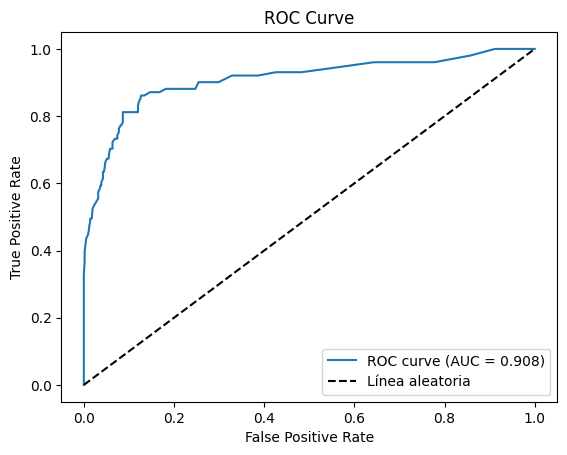

In [64]:
# Graficar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_randomforest_clf)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_best_randomforest_clf:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Línea aleatoria")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [65]:
# Importancia de características (Top 4)

importances_best_randomforest_clf = pd.Series(best_randomforest_clf.feature_importances_, index=X.columns)
top4_importances_best_randomforest_clf = importances_best_randomforest_clf.sort_values(ascending=False).head(4)
print("\nTop 4 características importantes:")
print(top4_importances_best_randomforest_clf)


Top 4 características importantes:
ContractRenewal    0.193914
MonthlyCharge      0.167485
DayMins            0.144827
CustServCalls      0.124968
dtype: float64


In [116]:
# Las variables más importantes para la predicción son:

# ContractRenewal: toma el valor 1 si el cliente ha renovado recientemente el contrato, 0 en caso contrario
# MonthlyCharge: factura mensual media
# DayMins: promedio de minutos diurnos al mes
# CustServCalls: número de llamadas al servicio de atención al cliente

# Lo cual tiene sentido para la naturaleza de dichas variables

### Actividad 7

Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a renunciar.

In [66]:
# Crear DataFrame con clientes y su propensión
clientes_test = X_test.copy()
clientes_test["prob_renuncia"] = y_prob_best_randomforest_clf
clientes_test["real"] = y_test.values
clientes_test

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,prob_renuncia,real
438,113,1,0,0.00,1,155.0,93,55.0,16.53,13.5,0.045455,0
2674,67,1,0,0.00,0,109.1,117,38.0,10.87,12.8,0.081818,0
1345,98,1,0,0.00,4,0.0,0,14.0,7.98,6.8,0.909091,1
1957,147,1,0,0.33,1,212.8,79,57.3,10.21,10.2,0.136364,0
2148,96,1,0,0.30,1,144.0,102,47.0,11.24,10.0,0.063636,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2577,157,1,0,0.00,2,185.1,92,50.0,10.65,8.5,0.027273,0
2763,116,1,1,2.21,3,155.7,104,65.1,9.27,8.2,0.045455,0
3069,148,1,1,2.67,1,158.7,91,67.7,8.03,9.9,0.072727,0
1468,75,1,1,1.13,3,117.5,102,49.3,10.34,4.2,0.018182,0


In [67]:
# Seleccionar los 15 clientes con mayor probabilidad a renunciar
top15 = clientes_test.sort_values("prob_renuncia", ascending=False).head(15)
top15

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,prob_renuncia,real
605,112,1,0,0.0,2,335.5,77,76.0,10.63,12.7,1.000000,1
3127,100,1,0,0.0,4,113.3,96,37.0,9.90,11.7,1.000000,1
1878,39,1,0,0.0,1,295.4,126,70.0,11.61,11.5,1.000000,1
1078,80,1,0,0.0,0,322.3,113,74.0,11.10,6.7,1.000000,1
2536,119,1,0,0.0,0,294.2,100,70.0,11.63,9.0,1.000000,1
2924,96,1,0,0.0,1,276.9,105,69.0,12.35,10.3,1.000000,1
3272,133,1,0,0.0,2,295.0,141,70.0,11.18,12.9,1.000000,1
859,93,1,0,0.0,3,267.9,114,65.0,11.15,11.3,1.000000,1
331,54,1,0,0.0,1,272.6,83,68.0,12.44,9.5,0.990909,1
2325,110,1,0,0.0,2,271.1,108,67.0,11.85,9.8,0.990909,1
